<a href="https://colab.research.google.com/github/KKobuszewski/aluminium-prediction/blob/main/Aluminium_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install statsmodels copent emd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 8.2 MB/s eta 0:00:00


In [1]:
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:           6
    Model:                79
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             0
    BogoMIPS:             4399.99
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 cl
                          flush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc re
                          p_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3
                           fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand
                           hypervisor lahf_lm abm 3dnowprefetch i

In [2]:
import os
import warnings
import datetime

import requests

import numpy as np
import pandas as pd

import scipy.signal

import statsmodels
import statsmodels.tsa
import statsmodels.tsa.stattools
import statsmodels.tools
#import statsmodels.tools.sm_exceptions
from statsmodels.tools.sm_exceptions import InterpolationWarning

import emd
import copent

import matplotlib.pyplot as plt
import matplotlib.dates

from IPython.display import HTML

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/'Kurs ML & AI'/'Stock analysis'
%ls

ModuleNotFoundError: No module named 'emd'

# Utility functions

In [11]:
def adf_test(timeseries, pvalue=0.05, truefalse=True):
  """
  See https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html.
  """
  test_result = statsmodels.tsa.stattools.adfuller(timeseries, autolag='AIC')
  test_pvalue = test_result[1]

  if truefalse is True:
    return test_pvalue < pvalue
  else:
    return test_pvalue

def kpss_test(timeseries, pvalue=0.05, truefalse=True):
  with warnings.catch_warnings(record=True) as w:
    #warnings.simplefilter("always")
    warnings.filterwarnings(action='always',
                            category=InterpolationWarning)
    test_result = statsmodels.tsa.stattools.kpss(timeseries, regression="c", nlags="auto")
    test_pvalue = test_result[1]
    if   (len(w) == 1) and ('p-value is greater' in str(w[-1].message)):
       print(str(w[-1].message))
    elif (len(w) == 1) and ('p-value is smaller' in str(w[-1].message)):
       pass
    else:
       print('KPSS Warning')
       print(w)


  if truefalse is True:
    return test_pvalue > pvalue
  else:
    return test_pvalue

def stationarity_test(timeseries, pvalue=0.05, verbose=1):
  adf_result = adf_test(timeseries, pvalue=pvalue, truefalse=True)
  kpss_result = kpss_test(timeseries, pvalue=pvalue, truefalse=True)

  if verbose > 0:
    print('Stationarity (ADF test): ', adf_result)
    print('Stationarity (KPSS test):', kpss_result)

  return adf_result and kpss_result

def remove_residual_emd(signal, n=1):
  imf_opts = {'sd_thresh': 0.05}
  imfs = emd.sift.sift(signal,imf_opts=imf_opts)
  if n > imfs.shape[1]:
    n = imfs.shape[1]
  return signal - imfs[:,-n:].sum(axis=1)

def ccf(p, q, stationarize=False):
  """
  source: https://www.datainsightonline.com/post/cross-correlation-with-two-time-series-in-python#google_vignette
  """
  if stationarize is True:
    p = remove_residual_emd(p, n=1)
    q = remove_residual_emd(q, n=1)
  p = (p - np.mean(p)) / (np.std(p) * len(p))
  q = (q - np.mean(q)) / (np.std(q))
  lags = scipy.signal.correlation_lags(len(p), len(q))
  return lags, np.correlate(p, q, 'full')

def ccf_plot(lags, ccf_values, title='', show=True, fig=None, ax=None):
  """
  source: https://www.datainsightonline.com/post/cross-correlation-with-two-time-series-in-python#google_vignette
  """
  if (fig is None) or (ax is None):
    fig, ax = plt.subplots(figsize=(9, 6))
  ax.plot(lags, ccf_values)
  ax.axhline(-2/np.sqrt(23), color='red', label='5% confidence interval')
  ax.axhline(2/np.sqrt(23), color='red')
  ax.axvline(x = 0, color = 'black', lw = 1)
  ax.axhline(y = 0, color = 'black', lw = 1)
  ax.axhline(y = np.max(ccf_values), color = 'blue', lw = 1, linestyle='--', label = 'highest +/- correlation')
  ax.axhline(y = np.min(ccf_values), color = 'blue', lw = 1, linestyle='--')
  ax.set(ylim = [-1, 1])
  ax.set_title(title, weight='bold', fontsize = 15)
  ax.set_ylabel('Correlation Coefficients', weight='bold', fontsize = 12)
  ax.set_xlabel('Time Lags', weight='bold', fontsize = 12)
  plt.legend()
  if show is True:
    plt.show()
  else:
    return fig, ax

# Data aquisition

## Al + Alpha Vintage API


Ogólnie Alpha Vintage: https://www.alphavantage.co/documentation/#symbolsearch

Pobieranie danych Aluminium

**Tylko dane z miesięczną rozdzielczością**

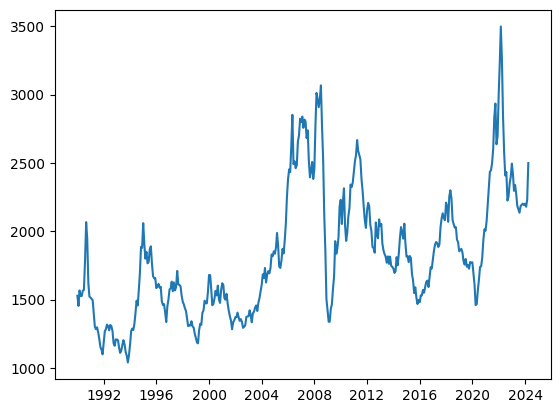

In [6]:
apikey = 'M6V1WYGSXGCN8V7Y'

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = f'https://www.alphavantage.co/query?function=ALUMINUM&interval=daily&apikey={apikey}'
r = requests.get(url)
data = r.json()

dates = []
price = []
for d in data['data']:
  if '1989-12-01' in d['date']:
    break
  dates.append( datetime.datetime.strptime(d['date'], '%Y-%m-%d').date() )
  price.append( float(d['value']) )

dates = np.array(dates, dtype=datetime.date)
price = np.array(price)

plt.plot(dates, price)
plt.show()

## Primary aluminium production

https://international-aluminium.org/statistics/primary-aluminium-production/

In [7]:
df = pd.read_csv('al_production_data.csv')[['From','To','Total']]

#df['From'] = pd.to_datetime(df['From'], format='%-%m-%d')
#df['To'] = pd.to_datetime(df['To'], format='%y-%m-%d')

df['From'] = df['From'].apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d').date())
df['To'] = df['To'].apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d').date())

#print(type(df['From'][0])); print(type(df['To'][0])); print(dates[-1], type(dates[0]))

idx = df['To'] >= dates[-1]
df = df[idx]

print(dates.shape, df.shape)
df['Date'] = dates[::-1]
df['Price'] = price[::-1]

df

(412,) (412, 3)


,From,To,Total,Date,Price
203,1989-12-01,1990-01-01,1623,1990-01-01,1528.000000
204,1990-01-01,1990-02-01,1639,1990-02-01,1454.000000
205,1990-02-01,1990-03-01,1533,1990-03-01,1567.000000
206,1990-03-01,1990-04-01,1642,1990-04-01,1526.000000
207,1990-04-01,1990-05-01,1596,1990-05-01,1527.000000
...,...,...,...,...,...
610,2023-11-01,2023-12-01,5851,2023-12-01,2192.005238
611,2023-12-01,2024-01-01,6042,2024-01-01,2201.566522
612,2024-01-01,2024-02-01,6062,2024-02-01,2179.457143
613,2024-02-01,2024-03-01,5667,2024-03-01,2229.441905


Combine two datasets

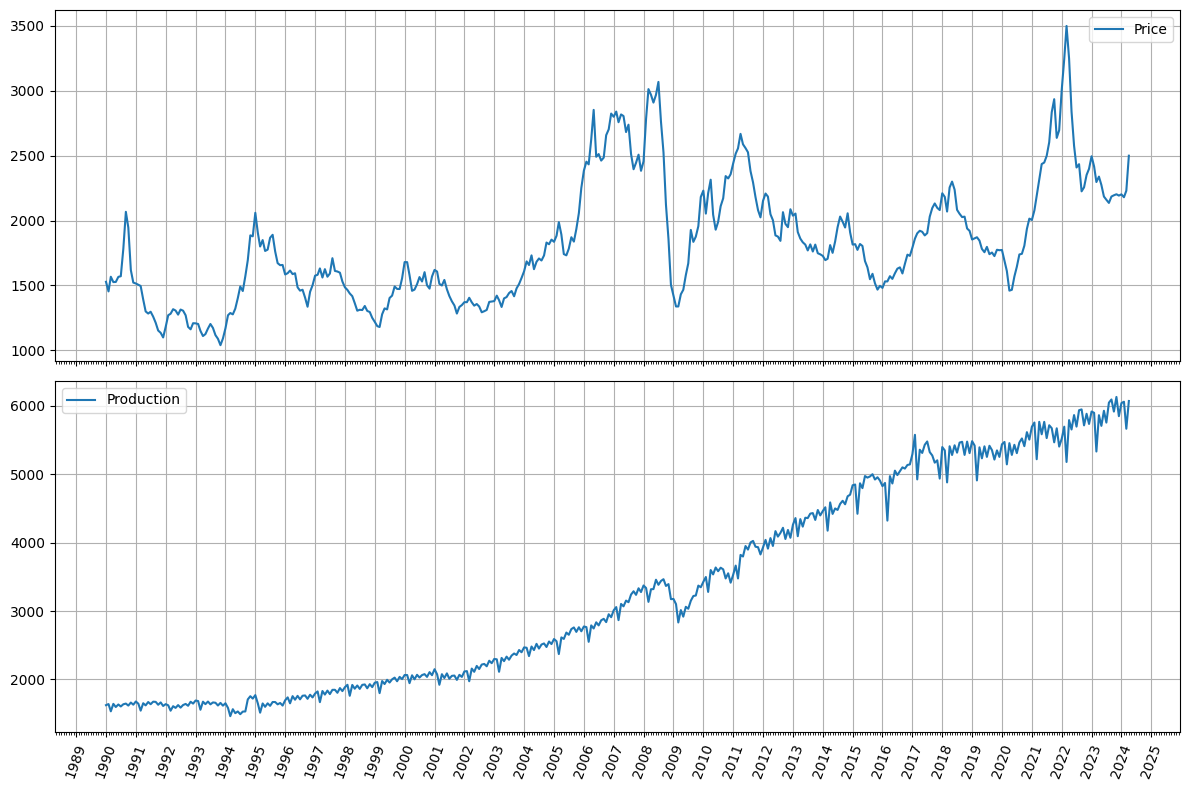

In [56]:
fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=[12.,8.])
ax1, ax2 = axes.ravel()

ax1.grid(True)
ax1.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax1.xaxis.set_minor_locator(matplotlib.dates.MonthLocator())
ax1.plot(df['To'], df['Price'], label='Price')
ax1.legend(loc='best')

ax2.grid(True)
ax2.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax2.xaxis.set_minor_locator(matplotlib.dates.MonthLocator())
ax2.plot(df['To'], df['Total'], label='Production')
ax2.legend(loc='best')

plt.setp( ax2.xaxis.get_majorticklabels(), rotation=70 )
fig.tight_layout()

plt.show()

# Stationarity and correlation

## Test stationarity


For testing stationarity we can use Augmented Dickey-Fuller test and Kwiatkowski-Phillips-Schmidt-Shin test from **statsmodels** package.

https://www.datainsightonline.com/post/cross-correlation-with-two-time-series-in-python#google_vignette

https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html


In [46]:
print(stationarity_test(df['Price']))

Stationarity (ADF test):  False
Stationarity (KPSS test): False
False


In [47]:
print(stationarity_test(df['Total']))

Stationarity (ADF test):  False
Stationarity (KPSS test): False
False


## Make timeseries stationary

In [27]:
price_stationarized = remove_residual_emd(df['Price'].to_numpy(), n=1)
print('Price: ', stationarity_test(price_stationarized))
print()

prod_stationarized = remove_residual_emd(df['Total'].to_numpy(), n=1)
print('Production: ', stationarity_test(prod_stationarized))

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

Stationarity (ADF test):  True
Stationarity (KPSS test): True
Price:  True

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

Stationarity (ADF test):  True
Stationarity (KPSS test): True
Production:  True


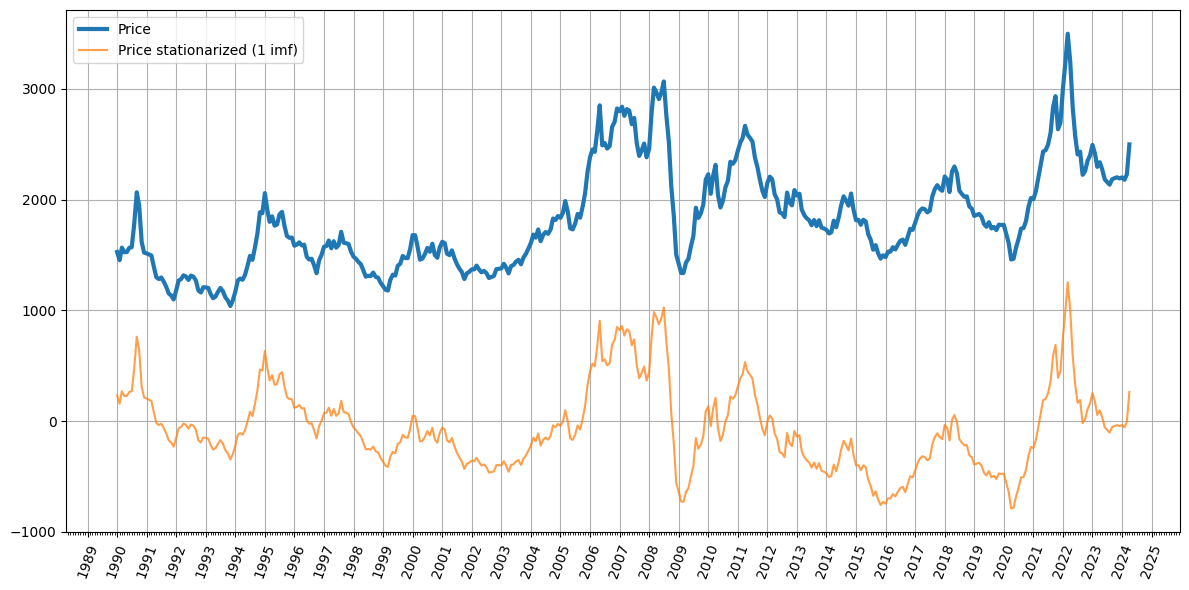

In [16]:
fig = plt.figure(figsize=[12.,6.])
ax1 = plt.gca()

ax1.grid(True)
ax1.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax1.xaxis.set_minor_locator(matplotlib.dates.MonthLocator())
ax1.plot(df['To'], df['Price'],linewidth=3.0, label='Price')
ax1.plot(df['To'], price_stationarized, label='Price stationarized (1 imf)', alpha=0.75)
ax1.legend(loc='best')

plt.setp( ax1.xaxis.get_majorticklabels(), rotation=70 )
fig.tight_layout()

plt.show()

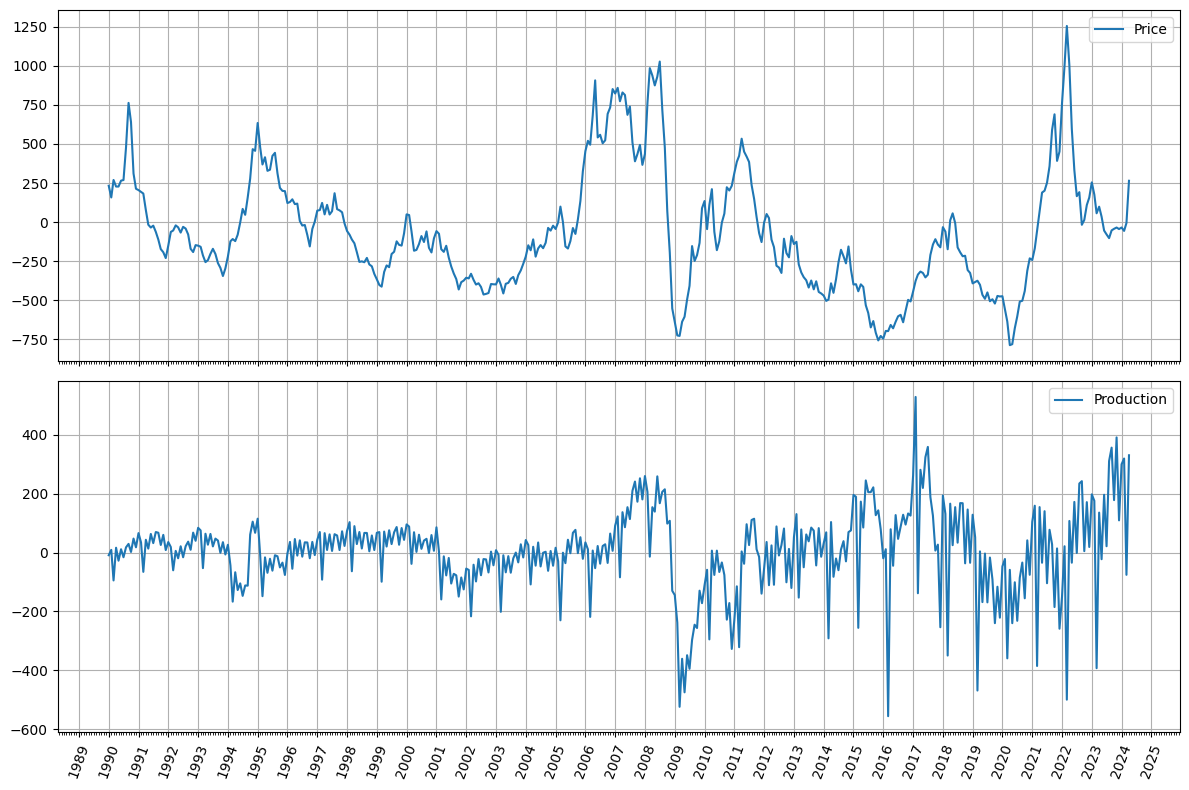

In [57]:
fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=[12.,8.])
ax1, ax2 = axes.ravel()

ax1.grid(True)
ax1.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax1.xaxis.set_minor_locator(matplotlib.dates.MonthLocator())
ax1.plot(df['To'], price_stationarized, label='Price')
ax1.legend(loc='best')

ax2.grid(True)
ax2.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax2.xaxis.set_minor_locator(matplotlib.dates.MonthLocator())
ax2.plot(df['To'], prod_stationarized, label='Production')
ax2.legend(loc='best')

plt.setp( ax2.xaxis.get_majorticklabels(), rotation=70 )
fig.tight_layout()

plt.show()

## Cross Correlations

https://www.datainsightonline.com/post/cross-correlation-with-two-time-series-in-python#google_vignette

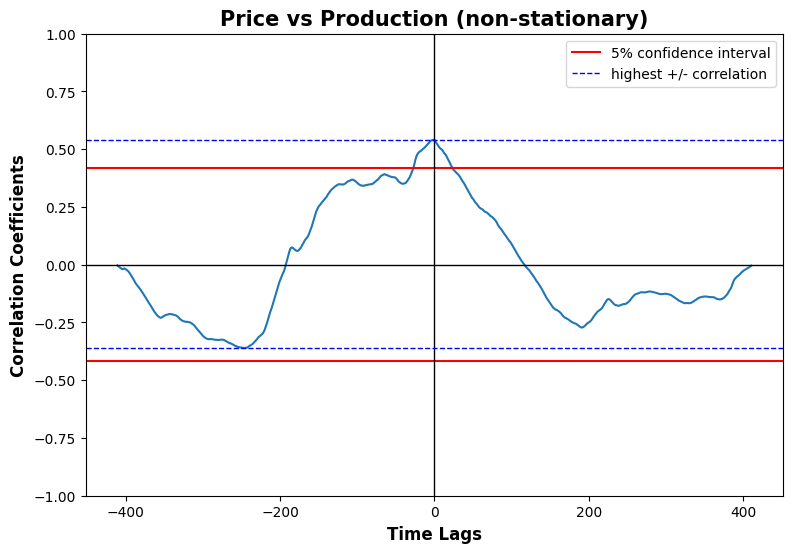

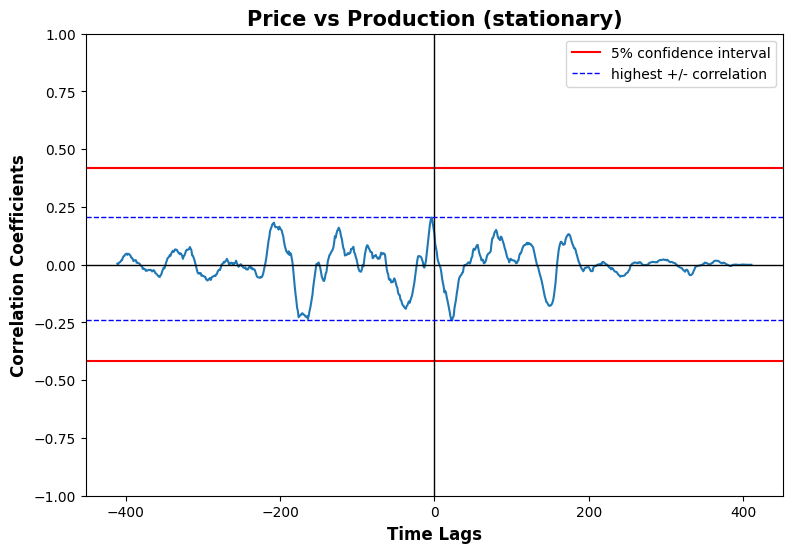

In [12]:
#lags, ccf_values = ccf(price_stationarized, prod_stationarized)

ccf_plot(*ccf(df['Price'].to_numpy(), df['Total'].to_numpy(), stationarize=False), title='Price vs Production (non-stationary)')
ccf_plot(*ccf(df['Price'].to_numpy(), df['Total'].to_numpy(), stationarize=True), title='Price vs Production (stationary)')

There is short-term correlation in monthly price/production data and price is more dependent on production (with lag up to about a year) than otherwise.

The correlation probably from general increasing trend in values of price and production.

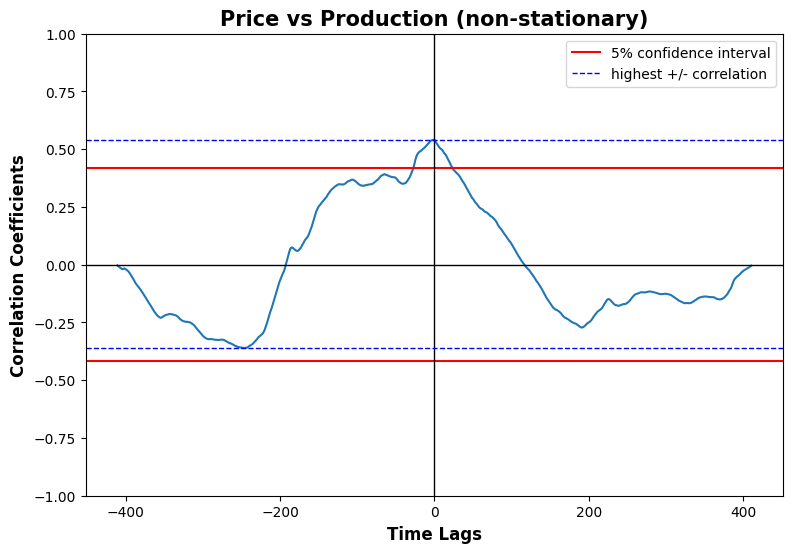

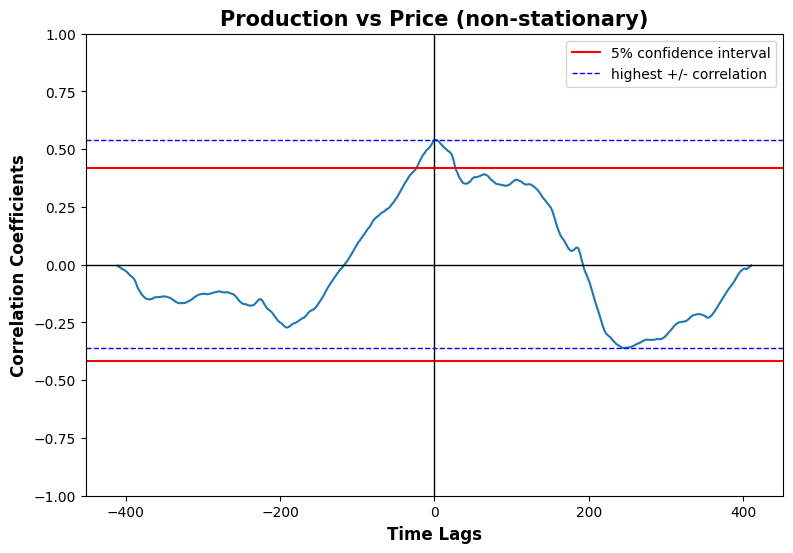

In [13]:
ccf_plot(*ccf(df['Price'].to_numpy(), df['Total'].to_numpy(), stationarize=False), title='Price vs Production (non-stationary)')
ccf_plot(*ccf(df['Total'].to_numpy(), df['Price'].to_numpy(), stationarize=False), title='Production vs Price (non-stationary)')

# Causality

## Transfer Entropy

In [1]:


price_stationarized = remove_residual_emd(df['Price'].to_numpy(), n=1)
print('Price: ', stationarity_test(price_stationarized))
print()

prod_stationarized = remove_residual_emd(df['Total'].to_numpy(), n=1)
print('Production: ', stationarity_test(prod_stationarized))

nlags = 24
lags = np.arange(1,nlags+1)
te_price = np.zeros(nlags)
te_prod = np.zeros(nlags)
for lag in lags:
	te_price[lag-1] = copent.transent(price_stationarized,prod_stationarized,lag)
	te_prod[lag-1] = copent.transent(prod_stationarized,price_stationarized,lag)

#print(lags)
#print(te)

fig = plt.figure(figsize=[10.,6.])
ax = plt.gca()

ax.grid(True)
ax.set_ylabel('Transfer entropy')
ax.set_xlabel('lag')
ax.plot(lags, te_price, label='Price vs Prod.')
ax.plot(lags, te_prod, label='Prod. vs Price')
ax.legend()

plt.show()

ModuleNotFoundError: No module named 'copent'

# Detrending

### EMD


See [https://emd.readthedocs.io](https://emd.readthedocs.io/en/stable/emd_tutorials/01_sifting/emd_tutorial_01_sift_03_ensemblesift.html#sphx-glr-emd-tutorials-01-sifting-emd-tutorial-01-sift-03-ensemblesift-py)

<class 'numpy.ndarray'> (412, 6)


[]

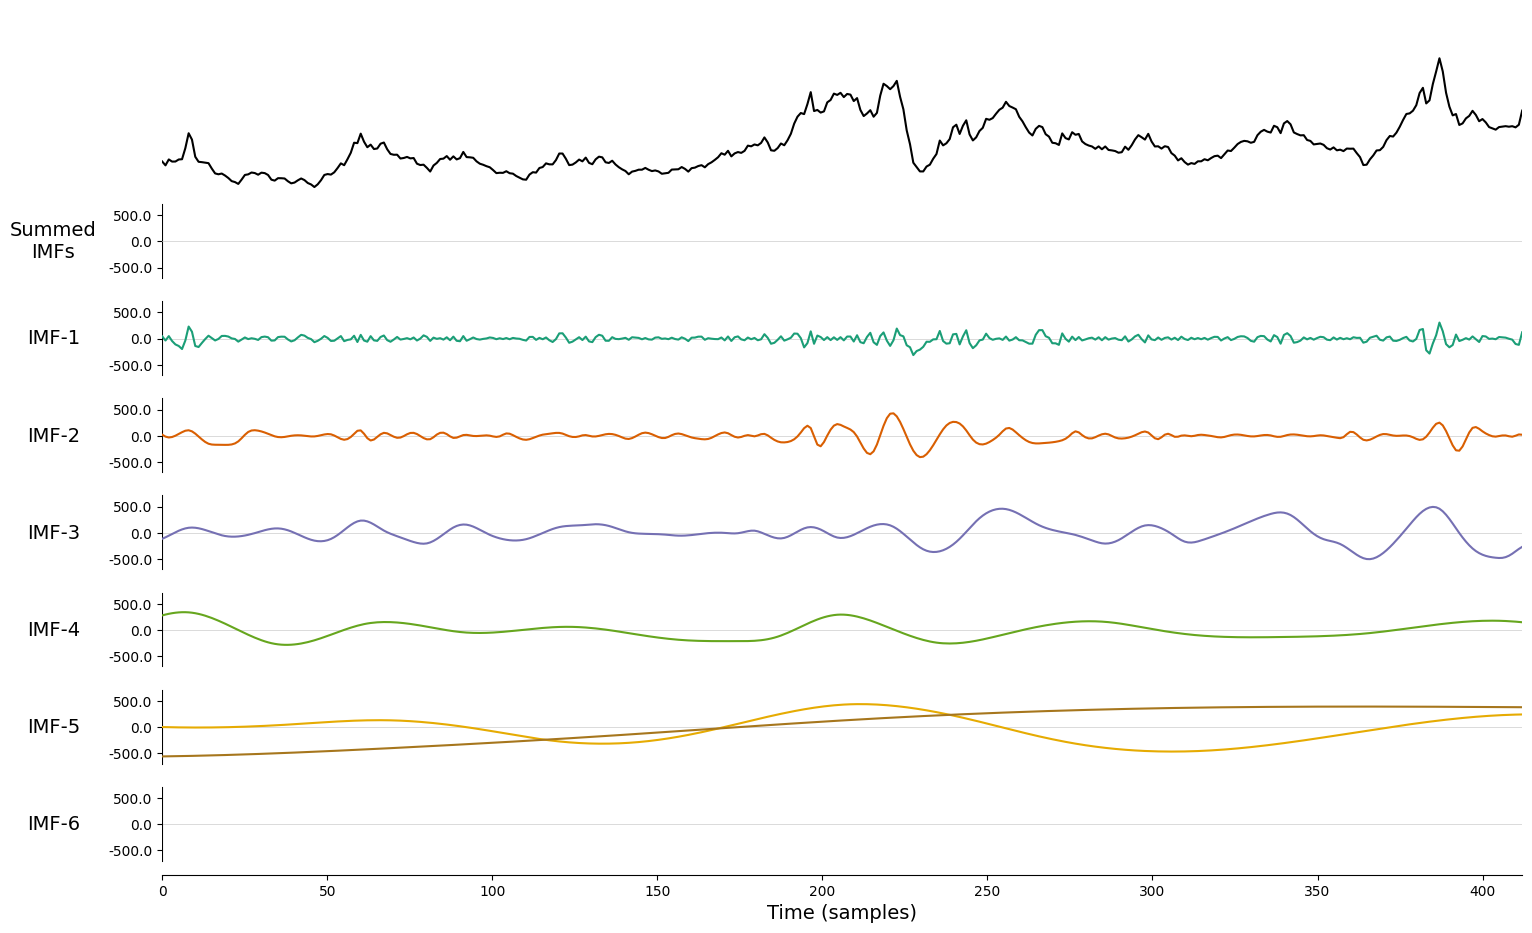

In [17]:
imf_opts = {'sd_thresh': 0.05}
#imfs_price = emd.sift.sift(df['Price'].to_numpy(),imf_opts=imf_opts)
imfs_price = emd.sift.ensemble_sift(df['Price'].to_numpy(), nensembles=12, nprocesses=12, ensemble_noise=1, imf_opts=imf_opts)
nimfs = imfs_price.shape[1]
print(type(imfs_price), imfs_price.shape)


emd.plotting.plot_imfs(imfs_price)
plt.plot()

#for imf in imfs_price:
#  print(type(imf), imf.shape)

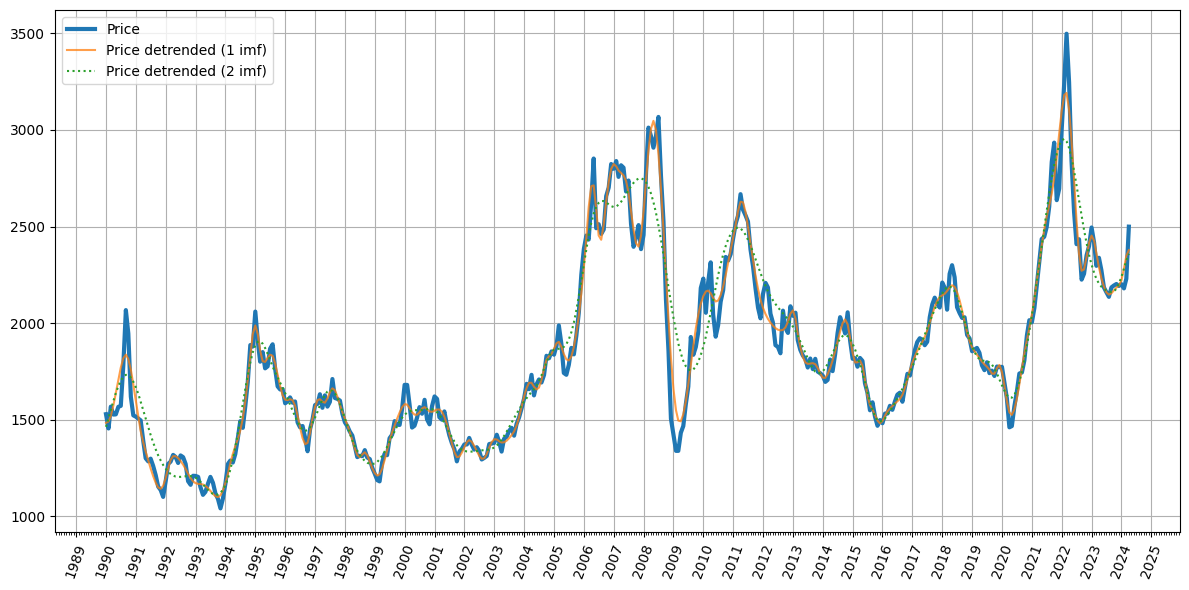

In [27]:
#fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=[12.,8.])
#ax1, ax2 = axes.ravel()
fig = plt.figure(figsize=[12.,6.])
ax1 = plt.gca()

ax1.grid(True)
ax1.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax1.xaxis.set_minor_locator(matplotlib.dates.MonthLocator())
ax1.plot(df['To'], df['Price'],linewidth=3.0, label='Price')
ax1.plot(df['To'], imfs_price[:,1:].sum(axis=1), label='Price detrended (1 imf)', alpha=0.75)
ax1.plot(df['To'], imfs_price[:,2:].sum(axis=1), label='Price detrended (2 imf)', linestyle=':')
ax1.legend(loc='best')


plt.setp( ax1.xaxis.get_majorticklabels(), rotation=70 )
fig.tight_layout()

plt.show()

### Rolling mean